# Generates the following files:
* See commented out `to_pickle` lines.

1. route_geoms_df.pkl
2. lxlgrids_davison.pkl
3. XDSegIds_for_all_trips.pkl

### Requires `inrix_grouped.pkl`  
    * This is an external file that lists all the road segment information covered by inrix.  

### These 2 are just variations of the `triplevel_df.parquet`, which is generated in the `day_ahead` and `any_day` files.
    1. triplevel_df_processed_time_window_with_IDs.pickle
    2. triplevel_df_processed_MAIN_NOTEBOOK.pickle

In [1]:
import os
os.chdir("/media/seconddrive/mta_stationing_problem")

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np

from tqdm import tqdm
from shapely.geometry import Polygon, LineString
import warnings
warnings.filterwarnings('ignore')
from pyspark import SparkContext,SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import Row, SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
from pyspark import SparkConf
import pandas as pd
import pickle
from tqdm import tqdm
spark = SparkSession.builder.config('spark.executor.cores', '8').config('spark.executor.memory', '80g')\
        .config("spark.sql.session.timeZone", "UTC").config('spark.driver.memory', '80g').master("local[26]")\
        .appName("wego-daily").config('spark.driver.extraJavaOptions', '-Duser.timezone=UTC').config('spark.executor.extraJavaOptions', '-Duser.timezone=UTC')\
        .config("spark.sql.datetime.java8API.enabled", "true").config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.autoBroadcastJoinThreshold", -1)\
        .config("spark.driver.maxResultSize", 0)\
        .config("spark.shuffle.spill", "true")\
        .config("spark.driver.extraJavaOptions", "-Dio.netty.tryReflectionSetAccessible=true")\
        .config("spark.executor.extraJavaOptions", "-Dio.netty.tryReflectionSetAccessible=true")\
        .config("spark.ui.showConsoleProgress", "false")\
        .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

/home/jptalusan/anaconda3/envs/py39/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


22/08/25 13:49:42 WARN Utils: Your hostname, scope-vanderbilt resolves to a loopback address: 127.0.1.1; using 10.2.218.69 instead (on interface enp8s0)
22/08/25 13:49:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/25 13:49:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/25 13:49:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/25 13:49:43 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
os.getcwd()

'/media/seconddrive/mta_stationing_problem'

# Generates 1x1 mile^2 grids across Nashville

In [ ]:
fp = os.path.join('data', 'shapefiles', "tncounty")
gdf_county = gpd.read_file(fp)
gdf_county.plot()
gdf_dav = gdf_county[gdf_county["NAME"] == "Davidson"]
gdf_david = gdf_dav.to_crs("EPSG:4326")
gdf_david.crs
xmin, ymin, xmax, ymax = gdf_dav.total_bounds
gdf_dav.total_bounds
length = 5280
wide = 5280

cols = list(np.arange(xmin, xmax + wide, wide))
rows = list(np.arange(ymin, ymax + length, length))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid = gpd.GeoDataFrame({'geometry':polygons})
fp = os.path.join('data', 'shapefiles', 'grid_shapes.shp')
grid.to_file(fp)
grid.plot(ax = gdf_dav.plot(color='blue'), color='none', edgecolor='red')
grids = grid.set_crs("EPSG:2274")
dav_grids = gpd.overlay(gdf_dav, grids, how='intersection')


dav_grids['row_num'] = np.arange(len(dav_grids))
dav_grids2 = dav_grids.to_crs("EPSG:4326")

# fp = os.path.join('data', '1x1grids_davidson.pkl')
# dav_grids2.to_pickle(fp)

# Gets all route geometries, probably easier from GTFS but it did not have all files i need (or i missed it)

In [ ]:
f = os.path.join('..', '..', 'data', 'processed_parquet_JP_all')
apcdata = spark.read.load(f)
apcdata = apcdata.sort("arrival_time")\
            .select("transit_date", "trip_id", "map_longitude", "map_latitude")\
            .groupby('transit_date', 'trip_id')\
            .agg(F.collect_list("map_longitude").alias("map_longitude"), F.collect_list("map_latitude").alias("map_latitude"))

apcdata = apcdata.drop("transit_date")
apcdata = apcdata.dropDuplicates(['trip_id'])
def create_lineString(x):
    geometry = [xy for xy in zip(x.map_longitude, x.map_latitude)]
    return LineString(geometry)

apcdf = apcdata.toPandas()
apcdf['geometry'] = apcdf.apply(lambda x: create_lineString(x), axis=1)
apcdf = apcdf.set_geometry('geometry')
apcdf = apcdf.drop(columns=['map_longitude', 'map_latitude'], axis=1)
# fp = os.path.join('data', 'route_geoms_df.pkl')
# apcdf.to_pickle(fp)

# Gets all XDSegIDs (Inrix segments) used in the trips

In [ ]:
# Load inrix segment data
fp = os.path.join('data', 'inrix_grouped.pkl')
with open(fp, "rb") as fh:
  inrix_segment_df = pickle.load(fh)

inrix_segment_df = inrix_segment_df.set_geometry('geometry')
inrix_segment_df = inrix_segment_df[inrix_segment_df['County_inrix'] == 'davidson']
davidson_segs = inrix_segment_df.XDSegID.unique().tolist()

In [ ]:
# Rtree would be faster
def find_grids_intersecting(gdf, linestring):
    spatial_index = gdf.sindex
    possible_matches_index = list(spatial_index.intersection(linestring.bounds))
    possible_matches = gdf.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(linestring)]
    return precise_matches

In [ ]:
# Generate/load 1x1 mile grids
fp = os.path.join('data', '1x1grids_davidson.pkl')
grids_df = pd.read_pickle(fp)
grids_df = grids_df.set_geometry('geometry')

In [ ]:
# Get route linestring data
fp = os.path.join('data', 'route_geoms_df.pkl')
trip_id_geom_data = pd.read_pickle(fp)
trip_id_geom_data.head(1)

In [ ]:
# Getting segments in trips
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import cpu_count
# Get APC data
fp = os.path.join('data', 'triplevel_df_processed_MAIN_NOTEBOOK.pickle')
df = pd.read_pickle(fp)
df = df.dropna()
df = df.drop_duplicates(subset=['trip_id', 'route_id_direction'], keep='first')
df = df.reset_index(drop=True)

CORES = cpu_count()

def merge_cluster(idx):
    trip_ids = df.iloc[idx].trip_id.tolist()
    all_used_segments = []
    for trip_id in trip_ids:
        route_linestring = trip_id_geom_data[trip_id_geom_data['trip_id'] == trip_id]['geometry'].values[0]
        if route_linestring is None: 
            print("trip id LS not found.")
        
        route_grids = find_grids_intersecting(grids_df, route_linestring)
        if route_grids.empty: 
            print("route grids for trip not found.")
        
        route_segments = inrix_segment_df[inrix_segment_df['geometry'].within(route_grids.unary_union)]['XDSegID'].tolist()
        if len(route_segments) == 0: 
            print("route segments for trip not found.")
        
        all_used_segments = list(set(all_used_segments + route_segments))
    return all_used_segments
o_index_group = np.array_split(df.index, CORES)

with ThreadPoolExecutor(max_workers=CORES) as pool:
    results = pool.map(merge_cluster, o_index_group)
results = list(results)
out = []
[out.extend(r) for r in results]
results = list(set(out))
fp = os.path.join('data', 'XDSegIDs_for_all_trips.pkl')
with open(fp, 'wb') as f:
    pickle.dump(results, f)

# For the simulator

In [6]:
f = os.path.join('/home/jptalusan/mta_stationing_problem/data/processed/apc_weather_gtfs.parquet')
apcdata = spark.read.load(f)
todelete = apcdata.filter('(load < 0) OR (load IS NULL)').select('transit_date','trip_id','overload_id').distinct()
todelete=todelete.withColumn('marker',F.lit(1))

#joining and whereever the records are not found in sync error table the marker will be null
apcdataafternegdelete=apcdata.join(todelete,on=['trip_id','transit_date','overload_id'],how='left').filter('marker is null').drop('marker')
apcdataafternegdelete = apcdataafternegdelete.sort(['trip_id', 'overload_id'])

get_columns = ['trip_id', 'transit_date', 'arrival_time', 
               'block_abbr', 'stop_sequence', 'stop_id_original',
               'load', 'ons',
               'route_direction_name', 'route_id',
               'dayofweek']
get_str = ", ".join([c for c in get_columns])

apcdataafternegdelete.createOrReplaceTempView("apc")

# # filter subset
query = f"""
SELECT {get_str}
FROM apc
"""
print(query)

apcdataafternegdelete = spark.sql(query)
df = apcdataafternegdelete.toPandas()
df['route_id_direction'] = df['route_id'].astype('str') + '_' + df['route_direction_name']


SELECT trip_id, transit_date, arrival_time, block_abbr, stop_sequence, stop_id_original, load, ons, route_direction_name, route_id, dayofweek
FROM apc



In [7]:
f = os.path.join('/home/jptalusan/mta_stationing_problem/data/processed/simulator_baseline.pkl')
df.to_pickle(f)

In [19]:
TIMEWINDOW = 60

## Occupancy Distribution

In [10]:
# df['route_id_direction'] = df['route_id'].astype('str') + '_' + df['route_direction_name']
df = df.dropna(subset=['arrival_time'])

In [34]:
from statsmodels.distributions.empirical_distribution import ECDF, monotone_fn_inverter

def get_ecdf(tdf, route_id_direction, stop, param='ons', window=60):
    tdf = tdf[(tdf['route_id_direction'] == route_id_direction) & 
            (tdf['stop_id_original'] == stop)]
    tdf.index = tdf['arrival_time']
    tdf = tdf.resample(f"{window}min").agg(np.sum).reset_index()
    tdf['hour'] = tdf['arrival_time'].dt.hour
    tdf['dow'] = tdf['arrival_time'].dt.dayofweek
    tdf = tdf[(tdf['hour'] == 12) & (tdf['dow'] == 5)].sort_values(param)
    plt.plot(np.sort(tdf[param].to_numpy()), np.linspace(0, 1, len(tdf), endpoint=False))
    ecdf = ECDF(tdf[param].to_numpy())
    mfi = monotone_fn_inverter(ecdf, tdf[param].to_numpy())
    return ecdf, mfi

In [39]:
max(pd.Timestamp('2020-02-04 05:09:42'), pd.Timestamp('2020-03-26 05:05:48'))

Timestamp('2020-03-26 05:05:48')

In [50]:
import datetime as dt

tdf = df[(df['route_id_direction'] == '19_FROM DOWNTOWN') &
         (df['stop_sequence'].isin([1, 2])) &
         (df['block_abbr'] == 1400)].sort_values('arrival_time')
tdf['hour'] = tdf.arrival_time.dt.hour
tdf = tdf[(tdf['hour'] == 5) & (tdf['dayofweek'] == 5)]
tdf['scheduled_timestamp'] = (tdf['arrival_time'] - dt.datetime(1970,1,1)).dt.total_seconds()
tdf['time_to_next_stop'] = tdf['scheduled_timestamp'].shift(-1) - tdf['scheduled_timestamp']
tdf.groupby('transit_date').mean()

,block_abbr,stop_sequence,load,ons,route_id,dayofweek,hour
transit_date,,,,,,,
2020-01-02,1400.0,1.5,3.0,1.0,19.0,5.0,5.0
2020-01-09,1400.0,1.5,7.0,3.0,19.0,5.0,5.0
2020-01-16,1400.0,1.5,4.0,1.5,19.0,5.0,5.0
2020-02-27,1400.0,1.5,1.0,0.5,19.0,5.0,5.0
2020-03-05,1400.0,1.5,1.0,0.5,19.0,5.0,5.0
2020-03-12,1400.0,1.5,5.0,2.5,19.0,5.0,5.0
2020-03-26,1400.0,1.5,1.0,0.0,19.0,5.0,5.0


(0.3553719008264463, array(14.97))

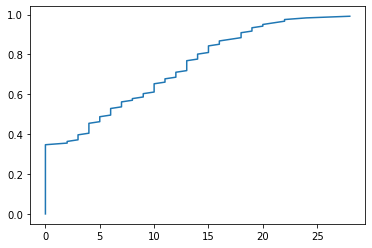

In [36]:
ecdf, mfi = get_ecdf(df, '19_FROM DOWNTOWN', 'MCC5_4', 'ons')
ecdf(0), mfi(0.85)

## Boarding Distribution

## Accident Probability